In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

# import custom modules
from custom_libs import db
from custom_libs import preprocessing
from custom_libs import classification
from custom_libs import plotting
from custom_libs import utils

## Loading del dataset e Preprocessing

In [2]:
df = db.get_dataset("McDonald_s_Reviews")
preprocessing.add_id_column(df, columns=["latitude", "longitude"])
preprocessing.add_rating_number_column(df)
df.head(2)


Number of unique ids:  39


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,rating_number,id
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,1,9.0
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,4,9.0


In [3]:
proprocessing_function = preprocessing.preprocess_text1
preprocessing.preprocess_dataframe(df, 'review', proprocessing_function)
df.head(2)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,rating_number,id,review_clean
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,1,9.0,look like someone spit food normal transaction...
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,4,9.0,far food atmosphere go staff make difference f...


In [4]:
# Salva il testo preprocessato in un file.
# Se sei curioso provala, siccome mi sembra tutto a posto la puoi anche eliminare.
with open('review_clean.txt', 'w') as f:
    for item in df['review_clean']:
        f.write("%s\n" % item)

In [ ]:
# inoltre per telegram ti serve fare questo sul df preprocessato, poi elimina
db.save_dataset(df, "McDonald_s_Reviews_preprocessed")

## Cose delle Classificazioni

In [5]:
classification.append_sentiment_for_each_row(df, 'review_clean', new_column_name='sentiment')
df[['review_clean', 'sentiment']]

,review_clean,sentiment
0,look like someone spit food normal transaction...,Positive
1,far food atmosphere go staff make difference f...,Positive
2,made mobile got speaker checked line moving le...,Negative
3,mc crispy chicken sandwich customer service qu...,Neutral
4,repeat time drive thru still manage mess suppo...,Negative
...,...,...
33391,treated badly,Negative
33392,service good,Positive
33393,remove hunger enough,Negative
33394,good lately become expensive,Positive


In [6]:
def plot_sentiment_word_clouds(df):
    for sentiment in classification.Sentiment.get_all():
        df_sentiment = df[(df['sentiment']==sentiment)]
        plotting.plot_word_cloud(df_sentiment, sentiment, 'review_clean')

# plot_sentiment_word_clouds(df)

In [7]:
# Ho spostato la funzione nella libreria utils percè ci servirà successivamente per il bot
current_position = [30.460718, -97.792874]
best_point = utils.select_best_restaurant_from_stars(df, current_position, max_distance=5)
best_point

,store_address,latitude,longitude
id,,,
9.0,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874


In [8]:
X, y = df['review_clean'], df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# test classificatori e vvectorizers

vectorizers = list()

vectorizers.append(CountVectorizer(stop_words='english'))
vectorizers.append(TfidfVectorizer())
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2)))
vectorizers.append(TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3)))

models = [PassiveAggressiveClassifier, MultinomialNB, SVC]

# classification.test_classifiers(models, vectorizers, x_train, x_test, y_train, y_test)

Accuracy: 0.938622754491018
Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.89      0.91      1663
     Neutral       0.88      0.94      0.91      1251
    Positive       0.97      0.96      0.96      3766

    accuracy                           0.94      6680
   macro avg       0.92      0.93      0.93      6680
weighted avg       0.94      0.94      0.94      6680

Confusion matrix, without normalization


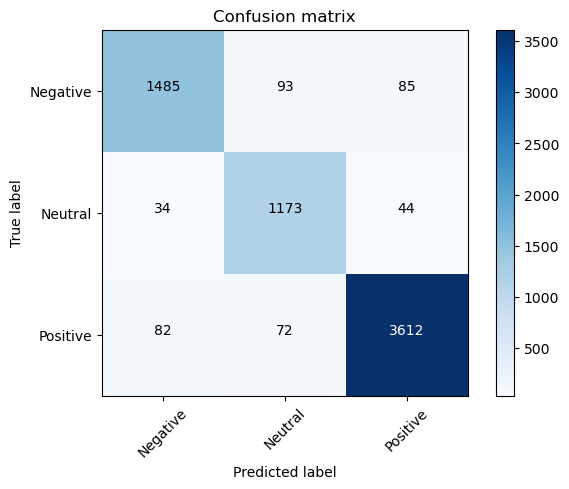

In [10]:
# Best combination of model and vectorizer
vectorizer = TfidfVectorizer()
x_train_trasformed = vectorizer.fit_transform(x_train)
x_test_trasformed = vectorizer.transform(x_test)

class_names = classification.Sentiment.get_all()
model = classification.test_classifier(PassiveAggressiveClassifier, x_train_trasformed, x_test_trasformed, y_train, y_test, class_names)

In [11]:
reviews = [
    "This restaurant has excellent service and delicious food.",
    "This restaurant sucks.", "This is fine",
    "This is dull",
    "its bad"
]

classification.predict_sentences(reviews, vectorizer, model, proprocessing_function)

,test_sent,prediction
0,restaurant excellent service delicious food,Positive
1,restaurant suck,Neutral
2,fine,Positive
3,dull,Neutral
4,bad,Negative
